## Project Overview:

This project was intended to practice and introduce new machine learning algorithms that can be applied to sentiment analysis and was framed around Kaggle’s Movie Sentiment Analysis on Movie Reviews Competition. Our personal goals and project layout was to first explore the data given to us using visualizations, follow online tutorials on getting started with sentiment analysis, trying out to improve scikit’s models using insights from data visualization, then implementing our own incremental versions of multinomial naive bayesian with smoothing from scratch without relying on scikit learn, and finally trying to set up a simple feedforward neural network model to get an introduction to it. 

## Competition and Data Introduction:

"There's a thin line between likably old-fashioned and fuddy-duddy, and The Count of Monte Cristo ... never quite settles on either side." The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee. In their work on sentiment treebanks, Socher et al. used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging. - Kaggle Site

In [36]:
# imports
import random
import pandas as pd
from pandas import Series,DataFrame
import thinkstats2
import thinkplot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# import functions
import utils

# get train & test csv files as a DataFrame
train = pd.read_csv("train.tsv", sep='\t')
test = pd.read_csv("test.tsv", sep='\t')

# drop nan data in train
train = train.dropna()
test = test.dropna()

### Data Exploration

In the Data Exploration Phase we tried to identify helpful relationships about our data that we can use to improve or adjust our model. We specifically looked at length, the relationship of phrases in the same sentence, word frequencies, and variation within the sentence and found:


1.Length has a positive correlation to the extremity of the provided phrase

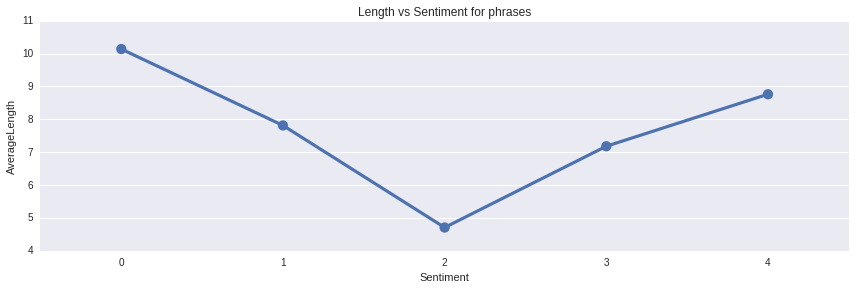

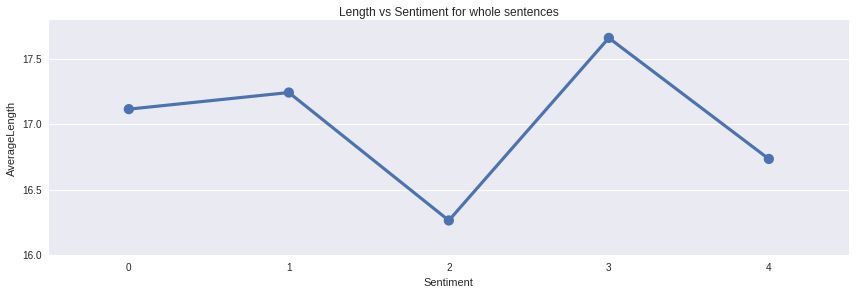

In [9]:
# add Length column to data
add_length(train)
# add WholeSentence column to data
add_whole_sentence(train)
# create a dataframe for  with analysis of the length data
length_phrase_df = get_average_length_sentiment(train[train['WholeSentence'] == False])
# create a dataframe with analysis of the length data
length_sentence_df = get_average_length_sentiment(train[train['WholeSentence'] == True])

# factor plot the length versus sentiment for both phrases and whole sentences
sns.factorplot('Sentiment','AverageLength', data=length_phrase_df, size=4, aspect=3)
sns.plt.title('Length vs Sentiment for phrases')
sns.factorplot('Sentiment','AverageLength', data=length_sentence_df, size=4, aspect=3)
sns.plt.title('Length vs Sentiment for whole sentences')

From the graph, we can see that there is a clear relationship between length and sentiment among phrases while the relationship of that for whole sentences are much more complex. That makes sense since sentences are made of several phrases and therefore are more complex than mere phrases.

2.There is variability within the phrases inside each sentence

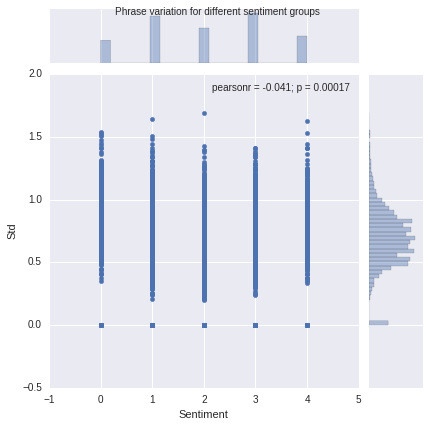

In [29]:
# get a dataframe grouped by sentence ID of train dataset
sentence_df = create_sentence_df(train)
# plot the joint plot of standard deviation of phases within same sentence ID over sentiments 
sns.jointplot(x="Sentiment", y="Std", data=sentence_df[['Sentiment', 'Std']])
sns.plt.suptitle("Phrase variation for different sentiment groups") 

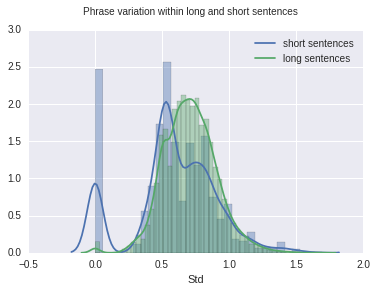

In [31]:
sns.distplot(sentence_df[(sentence_df['Length'] <= 8)].dropna()['Std'], kde_kws={"label": "short sentences"})
sns.distplot(sentence_df[(sentence_df['Length'] > 8)].dropna()['Std'], kde_kws={"label": "long sentences"})
sns.plt.suptitle("Phrase variation within long and short sentences") 

3.Many words have a large standard deviation and upon closer inspection 
Those with high variability are often the same as those in lists of “stop words” 
Words with less variability are usually strong adjectives or negations

/home/yuzhong/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


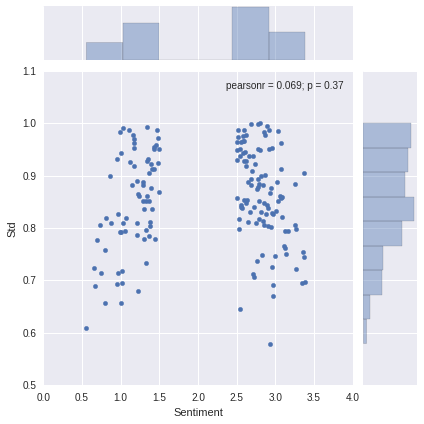

In [33]:
# create the dataframe for all words in train dataset
word_df = create_word_df(train)
#Start by removing the lower frequncy words and grabbing sentiment averages more extreme than 1.5 - 2.5
word_list_adapted = word_df[(word_df['Frequency'] > 100) & ((word_df['Sentiment'] >= 2.5) | (word_df['Sentiment'] <= 1.5))]
#To grab only strongly correlated words we want to grab ones with a very low std
word_list_adapted = word_list_adapted[ word_list_adapted['Std'] <= 1]
sns.jointplot(word_list_adapted['Sentiment'], word_list_adapted['Std'])

word_list_large = word_list_adapted[(word_df['Frequency'] > 100) & (word_df['Sentiment'] >= 2.5)]
word_list_small = word_list_adapted[(word_df['Frequency'] > 100) & (word_df['Sentiment'] <= 1.5)]  

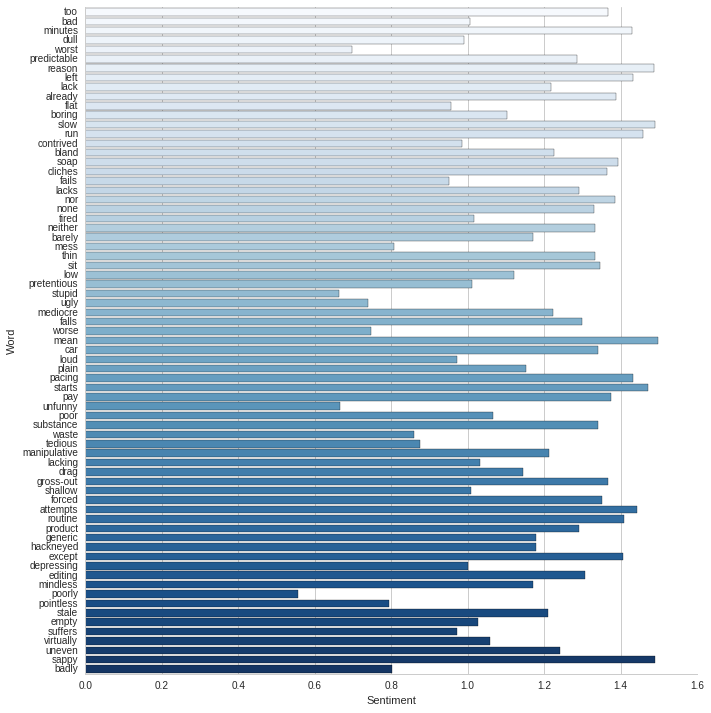

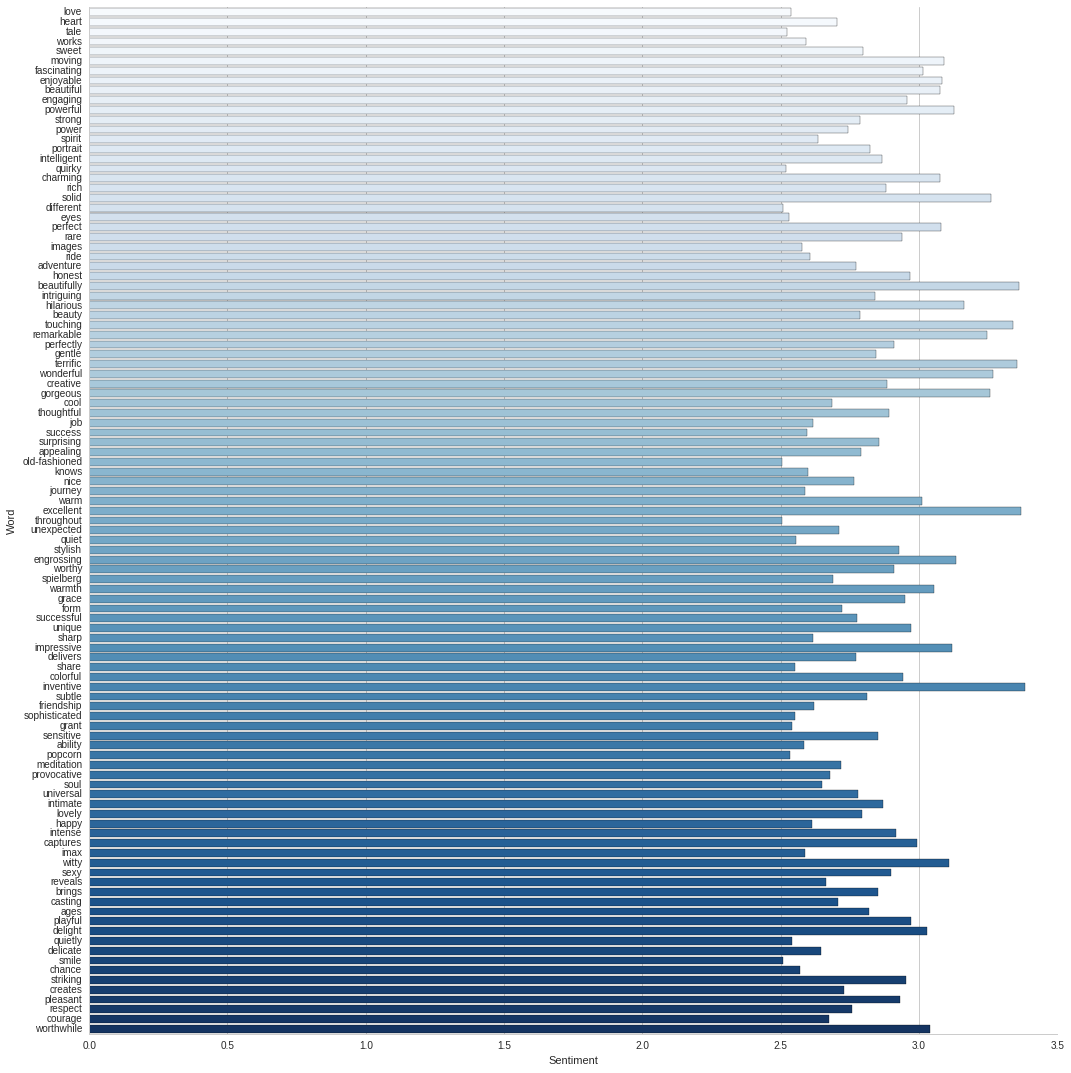

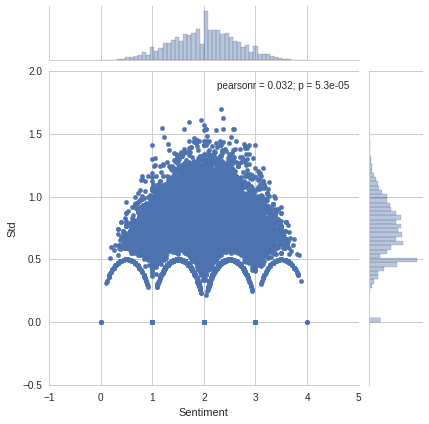

In [34]:
sns.set_style("whitegrid")
# ax = sns.barplot(x='Sentiment',y = 'Word' ,data=word_list_adapted,size=5, aspect=1)
sns.factorplot(x='Sentiment',y='Word', data=word_list_small,kind="bar",palette="Blues",size=10,aspect=1,legend_out=False);
sns.factorplot(x='Sentiment',y='Word', data=word_list_large,kind="bar",palette="Blues",size=15,aspect=1,legend_out=False);
sns.jointplot(word_df['Sentiment'], word_df['Std']);

## Using Bag of Words with SciKit Learn:

Bag of words consists of transforming each data point (sentence) into a sparse vector that corresponds a consistent row of word - index relationship. This can be easily done using scikit-learns Count Vectorizer. However the preprocessing of the data can result in different results. We tried to use our insights from the data exploration to use the std as a method of filtering out words with high standard deviations in addition to removing a list of stopwords from online. 

However, our changes for the model actually decrease the score in both training and testing data. We think that is because the word vectorizing tool may have a better algorithm for choosing the most influential words than just standard deviation and sentiment of the word. The scikit learn tool may choose the word not only depends on the context in provided data but also from more extensive language data. 

We first followed the bag of words kaggle tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words) to create a (256060, 1000) bag of words as a feature map, and applied random forest classification to fit our trainning data. Due to limitedness of memory, we were only able to perform random forest classification at tree level of 10. And we achieved score of 0.56750 in Kaggle. We then used scikit's naive bayesian model and explored using - tfidf - simple frequencies - our own model(started) Naive Bayesian appeared to work better and we will be further working on improving it later before moving onto more techniques


## Naive Bayesian By Hand:

Naive Bayesian is a simple but powerful probabilistic classifier that relies on applying Baye’s theorem to data by assuming that the features (in a bag of words case each word feature) are strongly independent. We specifically chose to do our own implementation because of the simplistic nature but also common application of this technique in sentiment analysis. 
To learn about the math and its applications to sentiment analysis we followed http://blog.datumbox.com/machine-learning-tutorial-the-naive-bayes-text-classifier/
as a guide and then created our own implementation of the mathematical equations for Multinomial Bayesian Classifier, Multinomial Bayesian Classifier with smoothing, and Binarized Multinomial Bayesian Classifier with smoothing. 

Math and Code Explanation:

1. To apply naive bayesian to our kaggle project we have 5 separate outcomes that we will need to calculate the probability of for each phrase we are provided and need a set of 5 class probabilities and a reference set of 5 outcome probabilities for each word. 

2. We can get the class probabilities fairly easily by counting the number of phrases with that sentiment and dividing by the total number of phrases

3. We will can get the frequency per word for each probability and then calculate the probability for each of the class probabilities by dividing the the total number of occurrences that word occurs in any given sentiment outcome by the frequency of word

4. Then, to get the probability of a phrase or sentence we multiply the probability for each word in that phrase against the probability of any document that expresses that sentiment.

5. Finally the model can be improved by adding smoothing factors to the calculation of the word probabilities. 

<h4>
    Multinomial Naive Bayesian
</h4>
![Multinomial Naive Bayesian](https://lh3.googleusercontent.com/ydUn1a4Hqyl8E75aIXL--lcVq-hylEHu_IBzJs6nrvMASGnDw0QB6bvVG0F-zl7lyGLl=s0 "naivebaye2.PNG")
<h4>
    Multinomial Naive Bayesian w/ Smoothing
</h4>
![Multinomial Naive Bayesian w/ Smoothing](https://lh3.googleusercontent.com/psA_MlW1pfrk-iivWU4sQEzOc7zJluDuxJrbi0487zrh3atbGZP0gguK411kDTmrOaJj=s0 "naivebaye.PNG")


Lessons Learned from implementing different Bayesian classifiers

1. Smoothing makes a big difference. 
    a. We specifically implemented smoothing by adding 1 as part of additive smoothing
    b. We made the impact of any word that didn’t exist irrelevant
    c. We added the total # of the frequency of that word as a smoothing factor
2. Binarized was an expected and actual improvement because
    a. We only care about whether the word occurs in the sentence not how many times
    b. By only counting a word  once we reduce the impact and risk of overfitting

We started off by doing a multinomial naive bayesian model without any smoothing. Adding smoothing improved the score significantly and then we only counted the frequency of words inside a particular phrase bc we care about whether the word exist rather than how many times it occurs (Binarized multinomial). Our final combination of Binarized multinomial bayes with smoothing was the best outcome.

## Neural Network By Hand:

Learning about neural network is very interesting and rewarding. We followed the tutorial (http://neuralnetworksanddeeplearning.com/chap1.html) to create a simple feedforward neural network class that is trained through stochastic gradient descent and back propagation. The network is created with a single hidden layer of size 1000-30-5. The 1000 input features are the 1000 most important words from our bag of words. This gives us a score of 0.49515 in Kaggle. There are a lot to be improved in the current neural network. 

There are some interesting phenomenons when we were trying different architectures for the model. First, depth of the networks does not necessary contributes to the learning. We didn't see significant difference between single hidden layer neural networks and multi hidden layer neural networks. Also, since we are using stochastic gradient descent, the training result is sometimes very different for each batch. This makes sense since we are randomly choosing features to perform gradient descent. 

Lessons Learned from implementing nerual networks:

1. Multilayer without any interpretation and rationale does not improve the learning 

2. Increase the number of features for mini batches improves the performance and stability of learning while increasing the time to train the model as well

Next step:

1. Understand the reasonning behind certain architectures for neural networks and do research about the architecture of neural network for nlp to come up with a more suitable structure for our case

2. Build a convolutional neural network based on the architecture suggested in an article about convolutional neural networks for natural language processing (http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

3. Try unsupervised training on our phrases to allow the network to learn the pattern by itself.